# タイタニック生存予測 ランダムフォレスト

## データ取得
https://www.kaggle.com/c/titanic/data

## データの読み込み

In [1]:
import pandas as pd
df = pd.read_csv("titanic_train.csv")

## データ確認

In [2]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df.shape

(891, 12)

## sample

In [4]:
df.sample(n=3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
307,308,1,1,"Penasco y Castellana, Mrs. Victor de Satode (M...",female,17.0,1,0,PC 17758,108.9,C65,C
705,706,0,2,"Morley, Mr. Henry Samuel (""Mr Henry Marshall"")",male,39.0,0,0,250655,26.0,NaN,S
397,398,0,2,"McKane, Mr. Peter David",male,46.0,0,0,28403,26.0,NaN,S


## 前処理について

### 前処理とは何か

前処理とは、解析を行う前に、データを補正すること。

### なぜ前処理を行う必要があるのか

正しく解析ができないため。

### 前処理は具体的に何を行うか

具体的な前処理は、欠損値対応、外れ値の対応、データ操作。

### 前述した具体的な前処理について、その前処理を行うと何を得ることができるか

- 欠損値対応→欠損があると解析ができない

- 外れ値の対応→外れ値が存在したまま分析を進めてしまうと、分析結果が著しく変わって しまい、本来の性質と異なる結果が得られてしまうことがある

- データ操作→抽出、結合をおこない、解析しやすい状態にデータを成形できる

## 前処理について2

データを確認する際にどのような点を見るとよいか。

- 欠損地はないか
- 文字データはないか
- 不要なデータはないか

## 前処理を行う

In [5]:
def simplify_ages(df):
    df.Age = df.Age.fillna(-0.5)
    bins = (-1, 0, 5, 12, 18, 25, 35, 60, 120)
    group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
    categories = pd.cut(df.Age, bins, labels=group_names)
    df.Age = categories
    return df

def simplify_cabins(df):
    df.Cabin = df.Cabin.fillna('N')
    df.Cabin = df.Cabin.apply(lambda x: x[0])
    return df

def simplify_fares(df):
    df.Fare = df.Fare.fillna(-0.5)
    bins = (-1, 0, 8, 15, 31, 1000)
    group_names = ['Unknown', '1_quartile', '2_quartile', '3_quartile', '4_quartile']
    categories = pd.cut(df.Fare, bins, labels=group_names)
    df.Fare = categories
    return df

def format_name(df):
    df['Lname'] = df.Name.apply(lambda x: x.split(' ')[0])
    df['NamePrefix'] = df.Name.apply(lambda x: x.split(' ')[1])
    return df    

def drop_features(df):
    return df.drop(['Ticket', 'Name', 'Embarked'], axis=1)

def transform_features(df):
    df = simplify_ages(df)
    df = simplify_cabins(df)
    df = simplify_fares(df)
    df = format_name(df)
    df = drop_features(df)
    return df


df = transform_features(df)
df.head()


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,1,0,3,male,Student,1,0,1_quartile,N,"Braund,",Mr.
1,2,1,1,female,Adult,1,0,4_quartile,C,"Cumings,",Mrs.
2,3,1,3,female,Young Adult,0,0,1_quartile,N,"Heikkinen,",Miss.
3,4,1,1,female,Young Adult,1,0,4_quartile,C,"Futrelle,",Mrs.
4,5,0,3,male,Young Adult,0,0,2_quartile,N,"Allen,",Mr.


In [6]:
from sklearn import preprocessing
def encode_features(df):
    features = ['Fare', 'Cabin', 'Age', 'Sex', 'Lname', 'NamePrefix']

    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

df = encode_features(df)
df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,1,0,3,1,4,1,0,0,7,73,17
1,2,1,1,0,0,1,0,3,2,136,18
2,3,1,3,0,7,0,0,0,7,251,14
3,4,1,1,0,7,1,0,3,2,198,18
4,5,0,3,1,7,0,0,1,7,11,17


## 前処理の内容について

メソッドがそれぞれ何を行っているか、なぜそのようなことを行っているか(それによって得られるメリット)

### simplify_ages

年齢をカテゴリーに分類。
メリットは計算量の減少。

### simplify_cabins

Cabin列の欠損部分にNを挿入。1文字目のみに変更。
メリットは欠損補填、データの見やすさの向上。

### simplify_fares

Fareをカテゴリーに分類。
メリットは計算量の減少。

### format_name

Nameを空白で分解、1つ目をLname、2つ目をNamePrefixに設定しなおしている。
メリットは、データの見やすさの向上。

### drop_features

Ticket、Name、Embarkedのカラムを削除。
メリットは不要な情報を削除することによるスッキリ化。

### encode_features

文字データを数字にラベリング。訓練データとテストデータでラベル化が統一されるよう、concatしてからラベル化している。
メリットは学習できる数値への変換。

## モデル選択について記述せよ

### 今回は、生存予測（分類）を行いますが、この分類について使用できそうな手法を4つ

ランダムフォレスト、SVM、ディープラーニング、

### その手法の概要

ランダムフォレストは、。

### その手法の長所/短所をそれぞれ3つずつ

|モデル|長所|短所|
|:--|:--|:--|
|決定木|||
|ランダムフォレスト|||
|バギング|||
|ブースティング|||

## モデル選択の基準

どのような視点からモデルを選択すれば良いか、最低でも3つ以上の視点を記述すること

参考

- https://docs.microsoft.com/ja-jp/azure/machine-learning/studio/algorithm-choice
- https://goo.gl/VY6VDH

## モデル選択におけるデータ可視化

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

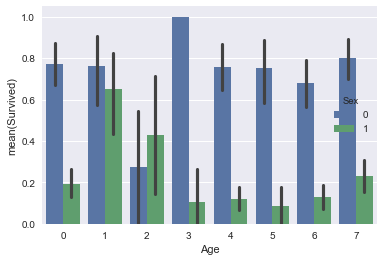

In [8]:
sns.barplot(x="Age", y="Survived", hue="Sex", data=df);

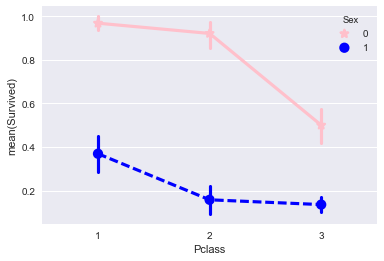

In [9]:
sns.pointplot(x="Pclass", y="Survived", hue="Sex", data=df,
              palette={1: "blue", 0: "pink"},
              markers=["*", "o"], linestyles=["-", "--"]);

## データ可視化の結果についての考察

上記の２つの可視化から分かったこと、また、モデル選択を考える場合、どのようなことが考えられるか

- 若いほうが生存率が高い
- 女性のほうが生存率が高い
- aaaaaaaaaaaaa

## データセットの分割

In [10]:
from sklearn.model_selection import train_test_split

data_train, data_test=train_test_split(df,test_size=0.2,random_state=0)

X_train = data_train.drop(['Survived', 'PassengerId'], axis=1)
y_train = data_train['Survived']

X_test = data_test.drop(['Survived', 'PassengerId'], axis=1)
y_test = data_test['Survived']

## ランダムフォレストについて

今回は、ランダムフォレストという手法を使用します。

### 今回の目的からランダムフォレストの手法が適する理由

aaaaaaaaaaaaa

## 学習

In [11]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
clf.fit(X_train, y_train)

print(clf.score(X_train, y_train))

0.981741573034


## accuracy

In [12]:
from sklearn.metrics import classification_report

print("Accuracy:", clf.score(X_test, y_test))
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=["not Survived", "Survived"]))

Accuracy: 0.832402234637
              precision    recall  f1-score   support

not Survived       0.83      0.91      0.87       110
    Survived       0.83      0.71      0.77        69

 avg / total       0.83      0.83      0.83       179



## ハイパーパラメータについて

### ハイパーパラメーターとは何か

### ランダムフォレストにおいてどのようなハイパーパラメーターがあるか4つ以上記述せよ

### 記述したハイパーパラメーターにおいて、それぞれどのような値が存在するか記述せよ

（そのハイパーパラメーターを変化させるとどのようなことが起きるかも記述すること）

## チューニング

In [13]:
from sklearn.grid_search import GridSearchCV

params = {'n_estimators': [4, 6, 9],
          'max_features': ['log2', 'sqrt','auto'],
          'criterion': ['entropy', 'gini'],
          'max_depth': [2, 3, 5, 10],
          'min_samples_split': [2, 3, 5],
          'min_samples_leaf': [1,5,8]}

mod = GridSearchCV(RandomForestClassifier(), params)
mod.fit(X_train, y_train)
print(mod.score(X_train, y_train))
print(mod.best_estimator_)

C:\Users\kakiuchi\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\kakiuchi\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


0.869382022472
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=5,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            n_estimators=9, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)


In [14]:
print("Accuracy:", mod.score(X_test, y_test))
y_pred = mod.predict(X_test)
print(classification_report(y_test, y_pred, target_names=["not Survived", "Survived"]))

Accuracy: 0.804469273743
              precision    recall  f1-score   support

not Survived       0.82      0.88      0.85       110
    Survived       0.78      0.68      0.73        69

 avg / total       0.80      0.80      0.80       179



## 検証について

### 検証は何か

### なぜ検証を行う必要があるのか(Accuracyだけではダメな理由も含めること)

### 主な検証方法について2つ以上記述せよ

## KFoldについて

### K-分割交差検証について説明せよ

標本群をK個に分割し、そのうちの1つをテストデータとし、残りを訓練データととして、全通りの検証を行うこと。

### K-分割交差検証はデータセットを何個に分割するか

K個

### データセットを分割する際、その個数はどのように考えると良いか



### K-分割交差検証は何回の検証を行うか

K回

### K-分割交差検証の結果は、最終的にどのように求められるか

K回の結果を平均する

## KFoldを実施する

In [32]:
from sklearn import cross_validation
import numpy as np

df = df.reindex(np.random.permutation(df.index))

X = df.drop(['Survived', 'PassengerId'], axis=1)
y = df['Survived']

model = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=5, max_features='log2', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=9, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

scores = cross_validation.cross_val_score(model, X, y, cv=10)


scores:  [ 0.86666667  0.83333333  0.7752809   0.92134831  0.79775281  0.82022472
  0.86516854  0.74157303  0.75280899  0.875     ]
Accuracy: 0.82 (+/- 0.11)


## KFoldの結果を確認する

In [33]:
print("scores: ", scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

scores:  [ 0.86666667  0.83333333  0.7752809   0.92134831  0.79775281  0.82022472
  0.86516854  0.74157303  0.75280899  0.875     ]
Accuracy: 0.82 (+/- 0.11)


## どの特徴量が重要であったかを調査

In [37]:
print(clf.feature_importances_)

[ 0.07908964  0.15145965  0.08780135  0.05135034  0.03996859  0.05635071
  0.05173366  0.30578174  0.17646431]


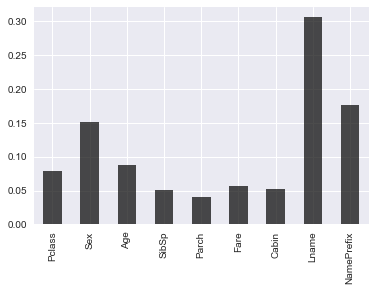

In [39]:
data = pd.Series(clf.feature_importances_, index=list(X_train.columns[:9]))
data.plot(kind='bar', color = 'k', alpha=0.7)